# Returning the echo distance

This notebook uses the water tank model from the previous notebook, with a solution to generating source positions and measurement setups and returning a point from the echo.

In [1]:
import numpy as np
import numpy.typing as npt
import math
import matplotlib.pyplot as plt 
from examples.seismic import Receiver, WaveletSource, RickerSource, Model, TimeAxis,  plot_velocity, plot_shotrecord
from devito import TimeFunction, Eq, solve, Operator, ConditionalDimension
from scipy.signal import find_peaks, peak_prominences

plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size

## Grid Setup
Set velocity model and global parameters for water tank.

In [2]:
nx = 601
nz = 301
nb = 10
shape = (nx, nz)
spacing = (.0001, .0001) #60x30 cm, spacing is 1mm
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
v_obj = 3.24 # v in gold 3240 m/s
glass = 50 # size of the glass
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water 
v[:, -glass:] = v_glass
v[:glass, :] = v_glass
v[-glass:, :] = v_glass
v[::2, -glass-5:] = v_glass
# Define an object's velocity profile
r = 25
a, b = shape[0] / 2, shape[1] - r - glass
y, x = np.ogrid[-a:shape[0]-a, -b:shape[1]-b]
v[x*x + y*y <= r*r] = v_obj

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


## Define the positions of the sources and receivers

In [3]:
def srcPositions(cx: float, cy:float, alpha:float, ns:int, sdist:float) -> np.typing.NDArray:
    assert alpha >= 0 and alpha < 180
    assert ns > 0
    dx = sdist * math.sin(math.pi / 180 * alpha)
    dy = sdist * math.cos(math.pi / 180 * alpha)

    res = np.zeros((ns, 2))
    res[:, 0] = np.linspace(cx - dx * (ns - 1) / 2, cx + dx * (ns - 1) / 2, num = ns)
    res[:, 1] = np.linspace(cy - dy * (ns - 1) / 2, cy + dy * (ns - 1) / 2, num = ns)
    return res

In [4]:
class SineSource(WaveletSource):
    @property
    def wavelet(self):
        t0 = self.t0 or 1 / self.f0
        a = self.a or 1
        r = (np.pi * self.f0 * (self.time_values - t0))
        wave = a * np.sin(r) + a*np.sin(3*(r+np.pi)/4)
        wave[np.searchsorted(self.time_values, 4*2/self.f0):] = 0
        return wave

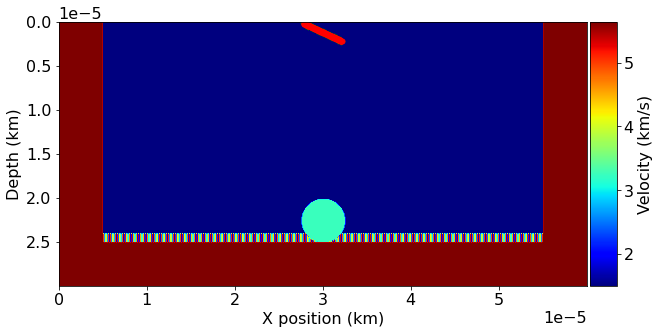

In [5]:
# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .05  # Simulation lasts tn milliseconds
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 128; # number of sources
nr = ns; # number of receivers
depth = 0.001
wavelength = v_water / f0 # 0.03 cm
source_distance = wavelength / 8
width = ns * source_distance
alpha = 65 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(
    name='src',
    grid=model.grid,
    f0=f0,
    time_range=time_range,
    npoint=ns)

src.coordinates.data[:, -1] = depth
src.coordinates.data[:] = pos[:]

rec = Receiver(
    name='rec',
    grid=model.grid,
    npoint=nr,
    time_range=time_range) 

rec.coordinates.data[:, -1] = depth
rec.coordinates.data[:] = pos[:]

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

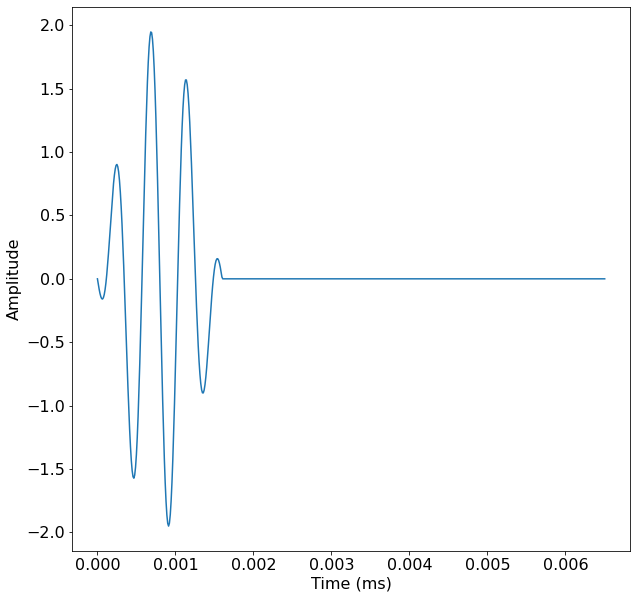

In [6]:
plt.figure()
plt.plot(src.time_values[0:600], src.data[:600,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

## Operator and plot velocity profile

Operator `Kernel` ran in 1.13 s


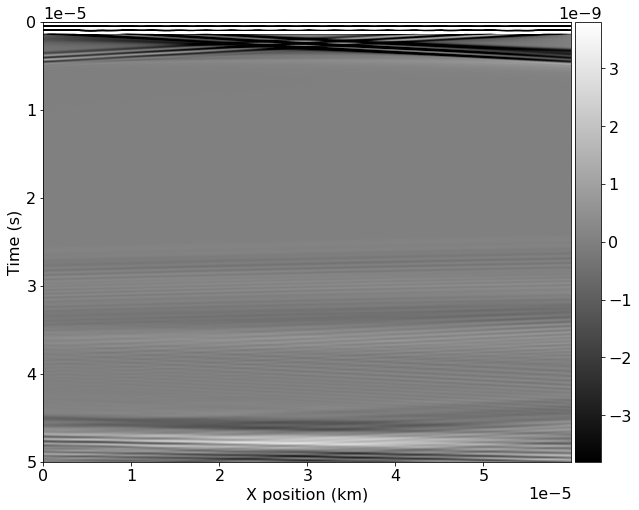

In [7]:
u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

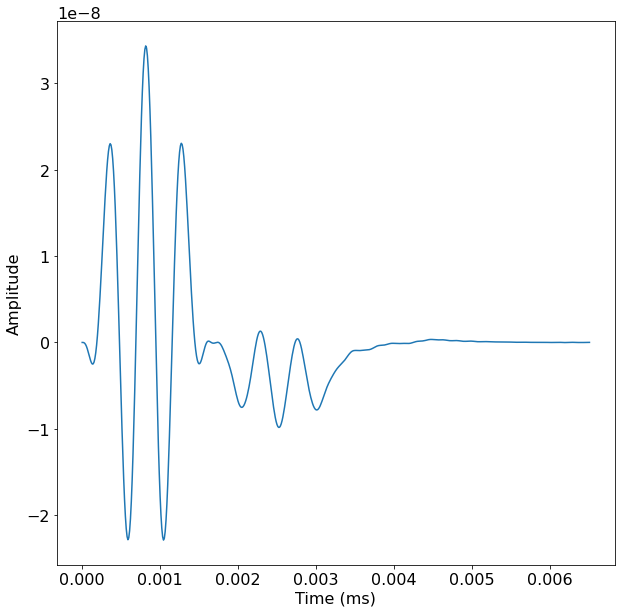

In [8]:
plt.figure()
plt.plot(src.time_values[:600],rec.data[:600,64])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

## Snapshotting

In [9]:
#Used for reshaping
vnx = nx + 2*nb
vnz = nz + 2*nb

# Using params for snapshotting
nsnaps = 103            # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=2,
                     save=nsnaps, time_dim=time_subsampled)

op_snapshot = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term, subs=model.spacing_map)  # operator with snapshots
# Run the operator for `(nt-2)` time steps:
op_snapshot(time=nt - 2, dt=model.critical_dt)

print("Saving snaps file")
print("Dimensions: nz = {:d}, nx = {:d}".format(nz + 2 * nb, nx + 2 * nb))
filename = "snapshots/snaps.bin"
usave.data.tofile(filename)

factor is 45


Operator `Kernel` ran in 1.21 s


Saving snaps file
Dimensions: nz = 321, nx = 621


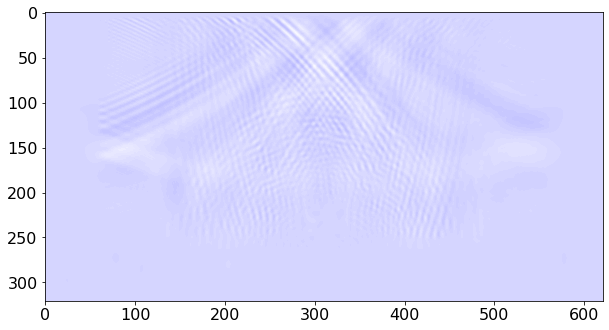

In [10]:
fobj = open("snapshots/snaps.bin", "rb")
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, vnx, vnz))
fobj.close()

imcnt = 1 # Image counter for plotting
plot_num = 20 # Number of images to plot
v_min = np.min(rec.data)
v_max = np.max(rec.data)
for i in range(0, plot_num):
   # plt.subplot(1, plot_num, i+1);
   imcnt = imcnt + 1
   ind = i * int(nsnaps/plot_num)
   plt.imshow(np.transpose(snaps[ind,:,:]), vmin=v_min, vmax=v_max, cmap="seismic")
   filename = 'snapshots/tmp_%04d.png' % i
   plt.savefig(filename)

plt.show() 

## Function for calculating the distance

In [11]:
def objDistance(receiver, timestep:float, width: float, v_env: float) -> float:
    cut = 600
    x = receiver[cut:]
    peaks, _ = find_peaks(x)
    prominences = peak_prominences(x, peaks)[0]
    first_peak = cut + peaks[(prominences - np.average(prominences)) > np.std(prominences)][0]
    distance = (((first_peak * timestep) / 2 ) / 1000 * v_env)
    return distance * 1e6

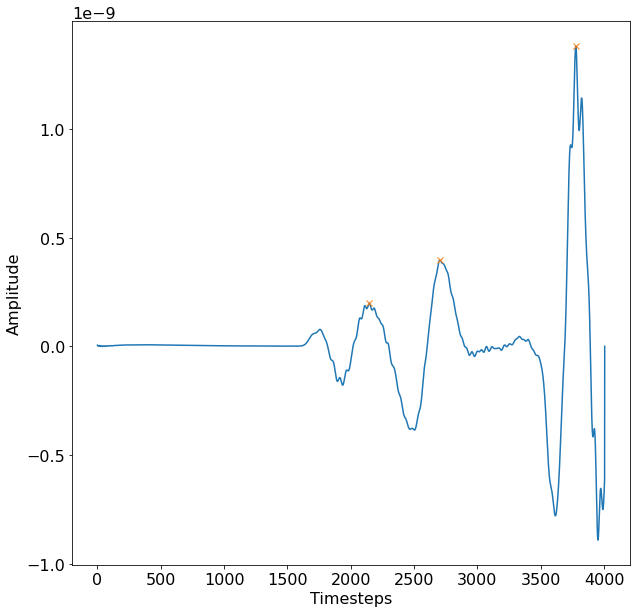

In [12]:
cut = 600
avg = np.average(rec.data, axis = 1)
x = avg[cut:]
peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
true_peaks = peaks[(prominences - np.average(prominences)) > np.std(prominences)]
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")
plt.plot(x)
plt.plot(true_peaks, x[true_peaks], "x")
plt.show()

In [13]:
print(objDistance(np.average(rec.data, axis = 1), dt, width, v_water))

22.374314479748136
